# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not rerun the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [1]:
student1 = "Quentin Rebjock"
student2 = "Augustin Prado"

**Seed value fixed because the hash function depends on the operating system :**

In [2]:
hash_value = 1993331184

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [3]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io
%matplotlib inline  

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
#np.random.seed(hash(student1 + student2) % 2**32)
np.random.seed(hash_value)
subset_of_classes = np.random.choice(range(10), 5, replace = False)

Using TensorFlow backend.


Subset of class used:

In [4]:
# 1,0,9,3,4
subset_of_classes

array([1, 0, 9, 3, 4])

### Plotting

In [5]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [6]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('housenumbers/train_32x32.mat')
data_test = scipy.io.loadmat('housenumbers/test_32x32.mat')

x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [7]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

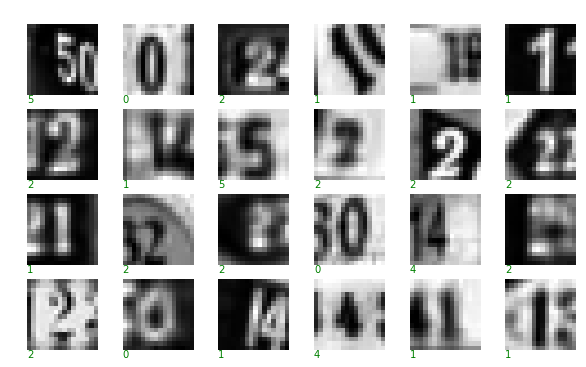

In [8]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [9]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [10]:
"""
Helper functions to save and load models and other
variables so they don't have to be calculated each time.
"""

def save_model(model, name):
    """
    Saves the parameters of the model.
    """
    model.save_weights('data/models/' + name + '.h5')
    
def load_model(model, name):
    """
    Loads the parameters for the model.
    """
    model.load_weights('data/models/' + name + '.h5')
    
import pickle

def save_obj(obj, name):
    with open('data/pickle/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('data/pickle/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [38]:
"""
Parameters
"""
batch_size = 128
num_classes = len(subset_of_classes)
epochs = 80
input_shape = (16*16,)
optimizer = SGD()

from keras.callbacks import EarlyStopping
stop_callback = EarlyStopping(monitor='acc', min_delta=0.0001, patience=11, verbose=1, mode='auto')

In [39]:
"""
Model architecture
"""

model1 = Sequential()
model1.add(Dense(num_classes, activation='softmax', input_shape=input_shape))

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 5)                 1285      
Total params: 1,285
Trainable params: 1,285
Non-trainable params: 0
_________________________________________________________________


In [40]:
"""
Training the model
"""

model1.compile(loss='categorical_crossentropy',
               optimizer=optimizer,
               metrics=['accuracy']
              )

history1 = model1.fit(x_train, y_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     verbose=0,
                     validation_data=(x_test, y_test),
                     callbacks=[stop_callback]
                    )

score = model1.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.5220666904
Test accuracy: 0.385495943142


In [20]:
"""
Saving the model. /!\ Do not run unless you want to override it.
"""
save_model(model1, 'exercise1')

In [28]:
"""
Loading the model and the history.
"""
load_model(model1, 'exercise1')

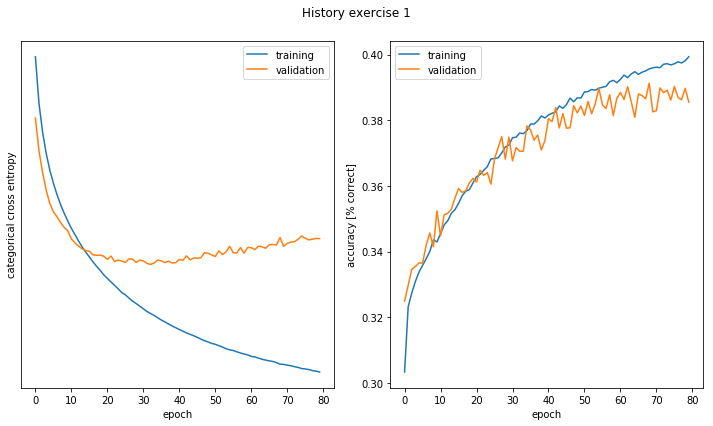

In [41]:
a = plot_history(history1, 'History exercise 1')

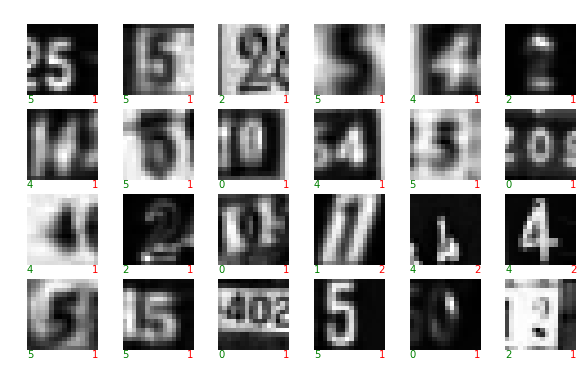

In [43]:
yhat_test = model1.predict_classes(x_test)
y_test_labels = np.argmax(y_test, axis=1)
error_indices = np.where(yhat_test != y_test_labels)[0]

a = plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)

From this plot it seems like the model is often wrong by predicting 1 : this class is overrepresented in the wrong labels.

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

In [60]:
"""
Parameters
"""
hidden_units = 64
batch_size = 128
num_classes = len(subset_of_classes)
epochs = 50
input_shape = (16*16,)

In [61]:
"""
Model architecture
"""
model2 = Sequential()

model2.add(Dense(hidden_units,
                 activation='relu',
                 input_shape=input_shape
                )
          )

model2.add(Dense(num_classes,
                 activation='softmax'
                )
          )

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


In [62]:
"""
Fitting the same model with several learning
rates and comparing the differences.
"""

test_losses = []
test_accs = []

learning_rates = np.logspace(-5, 1, 15)

for lr in learning_rates:
    
    model2.compile(loss='categorical_crossentropy', 
                   optimizer=SGD(lr=lr), 
                   metrics=['accuracy'])

    model2.fit(x_train, y_train,
               batch_size=batch_size,
               epochs=epochs,
               verbose=0,
               validation_data=(x_test, y_test)
              )
    
    score = model2.evaluate(x_test, y_test, verbose=0)
    test_losses.append(score[0])
    test_accs.append(score[1])
    print('learning rate: ', lr)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1], '\n')

learning rate:  1e-05
Test loss: 1.5724765705952848
Test accuracy: 0.30788099880589354 

learning rate:  2.6826957952797274e-05
Test loss: 1.559975296073353
Test accuracy: 0.31536574627381914 

learning rate:  7.196856730011514e-05
Test loss: 1.547314888726646
Test accuracy: 0.3212780678030065 

learning rate:  0.00019306977288832496
Test loss: 1.52527684014176
Test accuracy: 0.3309013145480848 

learning rate:  0.0005179474679231213
Test loss: 1.4822358875441413
Test accuracy: 0.3657462733505252 

learning rate:  0.0013894954943731374
Test loss: 1.3345368951587184
Test accuracy: 0.462796402290858 

learning rate:  0.003727593720314938
Test loss: 0.9671403518434786
Test accuracy: 0.6758286684490958 

learning rate:  0.01
Test loss: 0.726822166917039
Test accuracy: 0.7792942952461922 

learning rate:  0.026826957952797246
Test loss: 0.5632070332167621
Test accuracy: 0.8372853638556133 

learning rate:  0.07196856730011514
Test loss: 0.48473833152592366
Test accuracy: 0.8681678092811863 

In [109]:
"""
Saving the lists. /!\ Do not run it unless you want to override them.
"""
save_obj(test_losses, 'ex2_losses')
save_obj(test_accs, 'ex2_accs')

In [111]:
"""
Loading the lists.
"""
test_losses = load_obj('ex2_losses')
test_accs = load_obj('ex2_accs')

Plot with respect to different learning rates

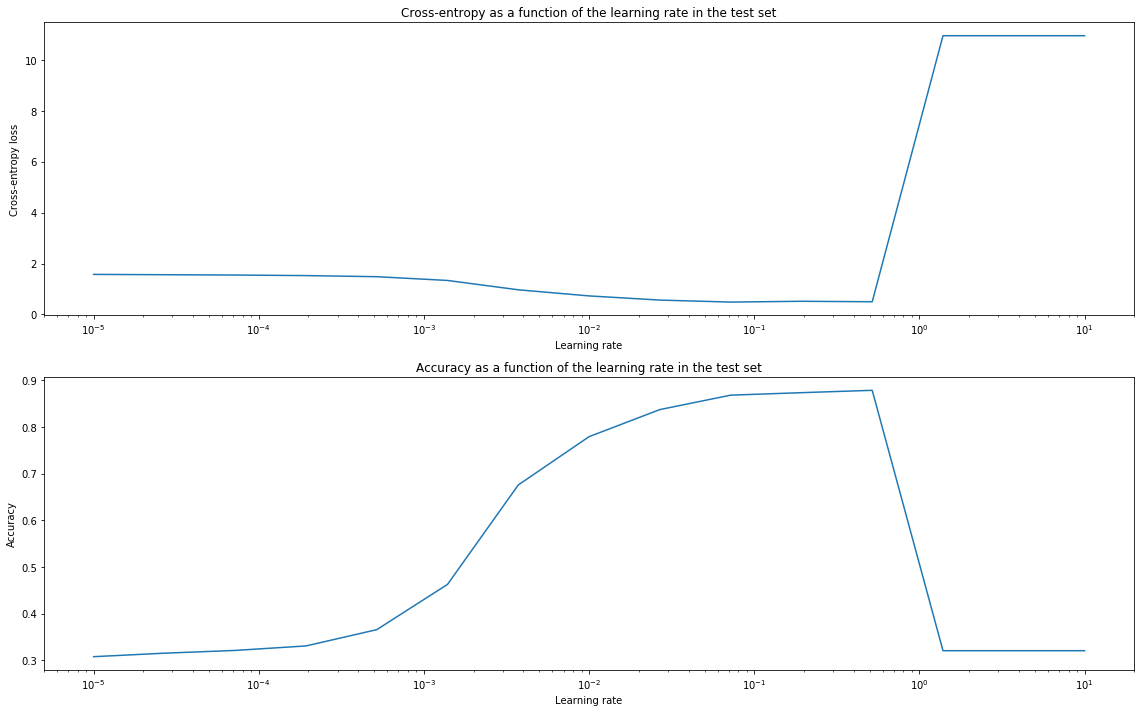

In [82]:
fig, ax = plt.subplots(2, 1, figsize=(16,10))

ax[0].semilogx(learning_rates, test_losses)
ax[0].set_title('Cross-entropy as a function of the learning rate in the test set')
ax[0].set_ylabel('Cross-entropy loss')
ax[0].set_xlabel('Learning rate')

ax[1].semilogx(learning_rates, test_accs)
ax[1].set_title('Accuracy as a function of the learning rate in the test set')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Learning rate')

plt.tight_layout()

plt.show()

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) When the learning rate is larger than 1, we have very bad results for both loss and accuracy, since the gradient step is too large, therefore not precise enough to reach a local minimum.   

B) When the learning rate is very small (10e-4 and less), the accuracy is very bad and loss 

#### With Adam optimizer

In [45]:
from keras.optimizers import Adam

In [50]:
"""
Parameters
"""
hidden_units = 64
batch_size = 128
num_classes = len(subset_of_classes)
epochs = 50
input_shape = (16*16,)
optimizer = Adam()

In [52]:
model2 = Sequential()

model2.add(Dense(hidden_units,
                 activation='relu',
                 input_shape=input_shape
                )
          )

model2.add(Dense(num_classes, activation='softmax'))

model2.compile(loss='categorical_crossentropy',
               optimizer = optimizer,
               metrics=['accuracy']
              )

history2_adam = model2.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=epochs,
           verbose=0,
           validation_data=(x_test, y_test)
          )

score = model2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1], '\n')

We achieve with Adam optimizer a better loss and accuracy, compared to the best result of the SGD optimizer for the same number of iterations (50 epochs)

- Loss: 0.43 (Adam) vs 0.47 (SGD)
- Accuracy: 0.89 (Adam) vs 0.87 (SGD)


In [57]:
model2 = Sequential()

model2.add(Dense(hidden_units,
                 activation='relu',
                 input_shape=input_shape
                )
          )

model2.add(Dense(num_classes, activation='softmax'))

model2.compile(loss='categorical_crossentropy',
               optimizer = SGD(lr=0.1),
               metrics=['accuracy']
              )

history2_sgd = model2.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=epochs,
           verbose=0,
           validation_data=(x_test, y_test)
          )

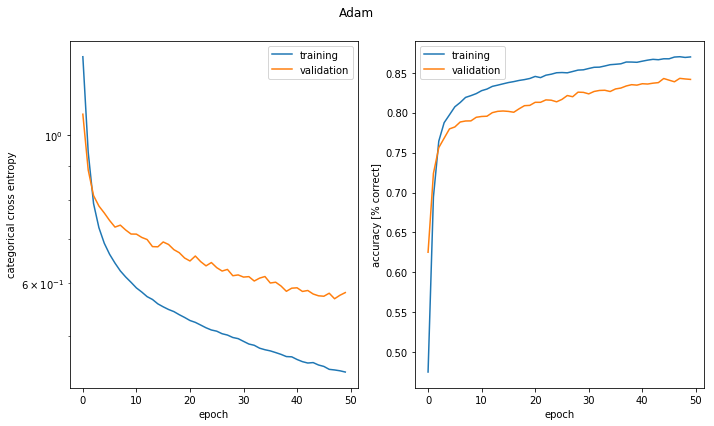

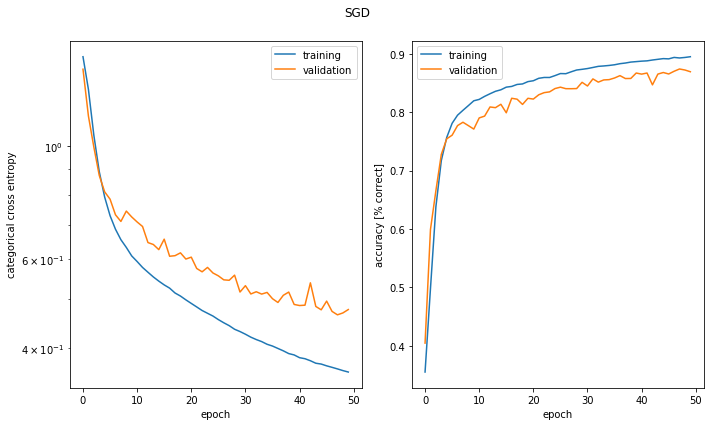

In [58]:
a = plot_history(history2_adam, 'Adam')
a = plot_history(history2_sgd, 'SGD')

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

In [60]:
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_shape=input_shape))
model2.add(Dense(5, activation='softmax'))

optimizer = Adam()
model2.compile(loss='categorical_crossentropy',
                  optimizer = optimizer,
                  metrics=['accuracy'])

history = model2.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=400,
                    verbose=0,
                    validation_data=(x_test, y_test))

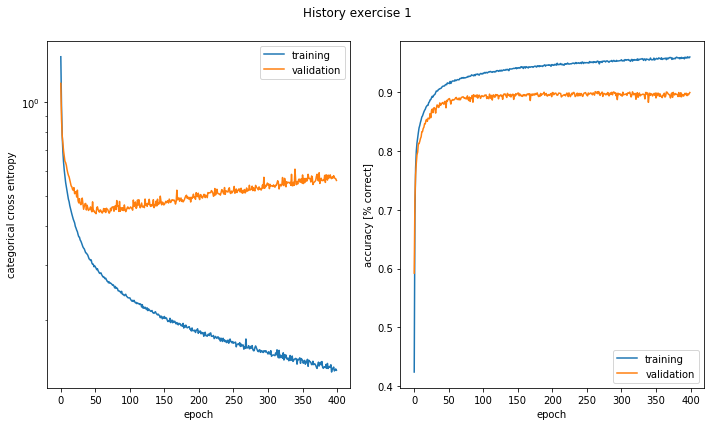

In [61]:
a = plot_history(history, 'History exercise 1')

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**:

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: 

## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

In [115]:
"""
Parameters
"""
hidden_units = [5, 50, 100, 300, 500, 650, 800, 1000]
batch_size = 128
num_classes = len(subset_of_classes)
epochs = 100
input_shape = (16*16,)
optimizer = Adam()

In [88]:
test_losses= []
test_accs= []

for nb_neurons in hidden_units:
    models = Sequential()
    models.add(Dense(nb_neurons, activation='relu', input_shape=input_shape))
    models.add(Dense(num_classes, activation='softmax'))
    
    models.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy']
                  )

    history = models.fit(x_train, y_train,
               batch_size=batch_size,
               epochs=epochs,
               verbose=0,
               validation_data=(x_test, y_test)
              )
    score = models.evaluate(x_test, y_test, verbose=0)
    test_losses.append(score[0])
    test_accs.append(score[1])
    print('For ', nb_neurons, ' hidden neurons in the model:')
    print('Test loss:', score[0])
    print('Test accuracy:', score[1], '\n')

For  10  hidden neurons in the model:
Test loss: 1.10579795529
Test accuracy: 0.589785521103 



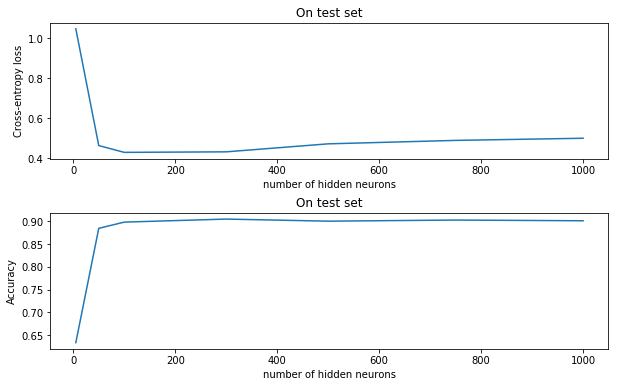

In [59]:
plt.subplots_adjust(hspace=0.4)
plt.subplot(2,1,1)
plt.plot(hidden, test_losses)
plt.title('On test set')
plt.ylabel('Cross-entropy loss')
plt.xlabel('number of hidden neurons')

plt.subplot(2,1,2)
plt.plot(hidden, test_accs)
plt.title('On test set')
plt.ylabel('Accuracy')
plt.xlabel('number of hidden neurons')
plt.show()

different random initializer

In [116]:
loss_multi = []
acc_multi = []
best_loss_multi = []
best_acc_multi = []
for nb_neurons in hidden_units:
    print('Processing for ', nb_neurons ,' neurons ...' )
    test_loss=[]
    test_acc=[]
    best_loss=[]
    best_acc=[]
    for i in range(30):
        models = Sequential()
        models.add(Dense(nb_neurons, activation='relu', input_shape=input_shape))
        models.add(Dense(num_classes, activation='softmax'))

        models.compile(loss='categorical_crossentropy',
                       optimizer=optimizer,
                       metrics=['accuracy']
                      )

        history = models.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=0,
                   validation_data=(x_test, y_test)
                  )
        best_loss.append(min(history.history['val_loss']))
        best_acc.append(min(history.history['val_acc']))
        
        score = models.evaluate(x_test, y_test, verbose=0)
        test_loss.append(score[0])
        test_acc.append(score[1])
        #print('For ', nb_neurons, ' hidden neurons in the model:')
        #print('Test loss:', score[0])
        #print('Test accuracy:', score[1], '\n')
        
    loss_multi.append(test_loss)
    acc_multi.append(test_acc)
    best_loss_multi.append(best_loss)
    best_acc_multi.append(best_acc)

Processing for  5  neurons ...


KeyboardInterrupt: 

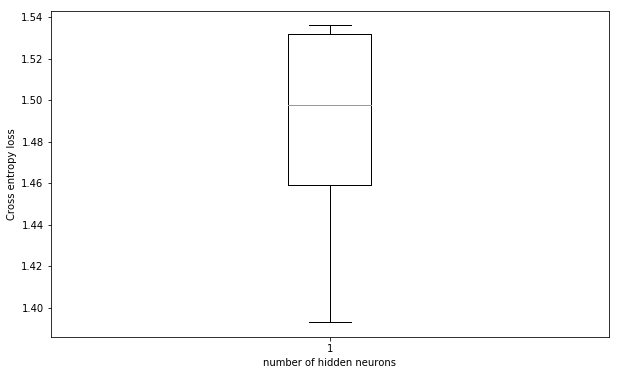

In [107]:
# multiple box plots on one figure
fig,ax = plt.subplots()
plt.boxplot(loss_multi)
#ax.set_xticklabels(hidden_units)
plt.title('')
plt.ylabel('Cross entropy loss')
plt.xlabel('number of hidden neurons')
plt.show()

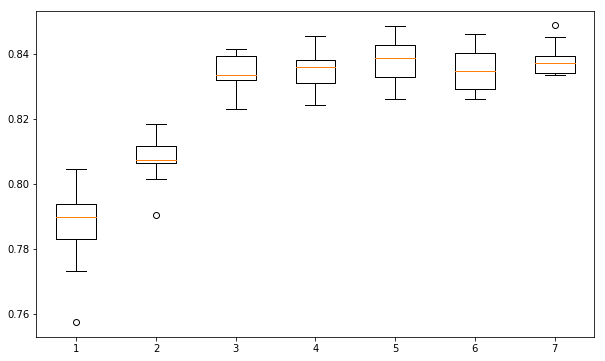

In [85]:
plt.figure()
plt.boxplot(data_accs[1:])
plt.show()

## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

**Question 1**

Let a network with $N_{in}$ inputs, $K$ hidden layers with $N_h$ units, and one output layer with $N_{out}$ dimensions. Let's calculate the number of parameters $N_p$. First consider $K = 1$. Then

$N_p = (N_{in} + 1)*N_h + (N_h + 1)*N_{out} = N_h * (N_{in} + N_{out} + 1) + N_{out}$

Each time another hidden layer with $N_h$ units is added, $N_h * (N_h + 1)$ parameters additional parameters appear.

So for any $K \geq 1$,

$N_p = N_h * (N_{in} + N_{out} + 1) + N_{out} + (K - 1) * N_h * (N_h + 1)$

$N_p = (K - 1) * N_h^{2} + (N_{in} + N_{out} + K) * N_h + N_{out}$

We get a quadratic equation that can be solved.

In [55]:
N_in = 16*16
K = 1
N_h = 100
N_out = 5

N_p = (K - 1) * N_h * N_h + (N_in + N_out + K) * N_h + N_out

print('There are {} parameters in a network with one hidden layer of 100 neurons.'.format(N_p))

There are 26205 parameters in a network with one hidden layer of 100 neurons.


In [56]:
K_list = [2, 3, 4]
N_h_list = []

for K in K_list:
    a = K - 1
    b = N_in + N_out + K
    c = N_out - N_p
    N_h_list.append(((-b + np.sqrt(b**2 - 4 * a * c)) / (2 * a)).astype(int))
    
N_h_2 = N_h_list[0]
N_h_3 = N_h_list[1]
N_h_4 = N_h_list[2]

print('The numbers of hidden units that approximate the best the number of parameters are '
      '{0}, {1} and {2} for respectively 2, 3 and 4 hidden layers.'.format(N_h_2, N_h_3, N_h_4))

The numbers of hidden units that approximate the best the number of parameters are 77, 66 and 59 for respectively 2, 3 and 4 hidden layers.


In [57]:
"""
Model with 1 hidden layer
"""

model1 = Sequential()

model1.add(Dense(N_h,
                 activation='relu',
                 input_shape=input_shape
                )
          )

model1.add(Dense(N_out,
                 activation='softmax'
                )
          )

"""
Model with 2 hidden layers
"""

model2 = Sequential()

model2.add(Dense(N_h_2,
                 activation='relu',
                 input_shape=input_shape
                )
          )

model2.add(Dense(N_h_2,
                 activation='relu',
                 input_shape=input_shape
                )
          )

model2.add(Dense(N_out,
                 activation='softmax'
                )
          )

"""
Model with 3 hidden layers
"""

model3 = Sequential()

model3.add(Dense(N_h_3,
                 activation='relu',
                 input_shape=input_shape
                )
          )

model3.add(Dense(N_h_3,
                 activation='relu',
                 input_shape=input_shape
                )
          )

model3.add(Dense(N_h_3,
                 activation='relu',
                 input_shape=input_shape
                )
          )

model3.add(Dense(N_out,
                 activation='softmax'
                )
          )

"""
Model with 4 hidden layers
"""

model4 = Sequential()

model4.add(Dense(N_h_4,
                 activation='relu',
                 input_shape=input_shape
                )
          )

model4.add(Dense(N_h_4,
                 activation='relu',
                 input_shape=input_shape
                )
          )

model4.add(Dense(N_h_4,
                 activation='relu',
                 input_shape=input_shape
                )
          )

model4.add(Dense(N_h_4,
                 activation='relu',
                 input_shape=input_shape
                )
          )

model4.add(Dense(N_out,
                 activation='softmax'
                )
          )

models = [model1, model2, model3, model4]

model1.summary()

model2.summary()

model3.summary()

model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               25700     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 77)                19789     
_________________________________________________________________
dense_5 (Dense)              (None, 77)                6006      
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 390       
Total params: 26,185
Trainable params: 26,185
Non-trainable params: 0
__

**Question 2**

In [58]:
"""
Hyper-parameters
"""

batch_size = 128
num_classes = len(subset_of_classes)
epochs = 70
input_shape = (16*16,)
optimizer = Adam()
num_runs = 5 #Environ 15 mins pour 1, faudra peut-être faire avec 3 et prendre le max comme demandé

In [65]:
loss_scores = []
accuracy_scores = []

for i, model in enumerate(models):
    loss_scores.append([])
    accuracy_scores.append([])
    for j in range(num_runs):
        model.compile(loss='categorical_crossentropy',
                       optimizer=optimizer,
                       metrics=['accuracy']
                      )

        history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0,
                            validation_data=(x_test, y_test)
                           )
        
        """score = model.evaluate(x_test, y_test, verbose=0)
        loss_score = score[0]
        accuracy_score = score[1]"""
        
        loss_scores[i].append(history.history['val_loss'])
        accuracy_scores[i].append(history.history['val_acc'])

In [67]:
"""
Saving the lists. /!\ Do not run it unless you want to override them.
"""
save_obj(loss_scores, 'ex5_losses')
save_obj(accuracy_scores, 'ex5_accs')

In [68]:
"""
Loading the lists.
"""
loss_scores = load_obj('ex5_losses')
accuracy_scores = load_obj('ex5_accs')

In [69]:
loss_scores = np.array(loss_scores)
accuracy_scores = np.array(accuracy_scores)

loss_scores = np.max(loss_scores, axis=(1, 2))
accuracy_scores = np.max(accuracy_scores, axis=(1, 2))

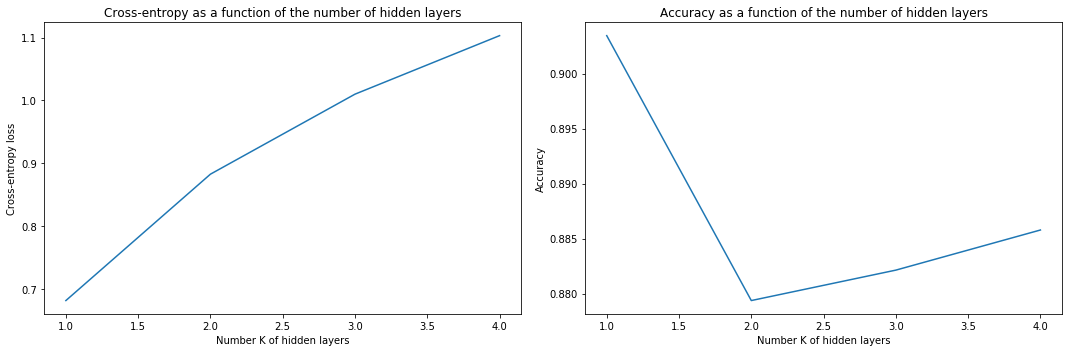

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(np.arange(1, 5), loss_scores)
ax[0].set_title('Cross-entropy as a function of the number of hidden layers')
ax[0].set_ylabel('Cross-entropy loss')
ax[0].set_xlabel('Number K of hidden layers')

ax[1].plot(np.arange(1, 5), accuracy_scores)
ax[1].set_title('Accuracy as a function of the number of hidden layers')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Number K of hidden layers')

plt.tight_layout()

plt.show()

In [ ]:
import seaborn as sns

#TODO : boxplot

## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution

In [44]:
"""
Parameters
"""

batch_size = 128
input_shape = (16, 16, 1)
num_classes = len(subset_of_classes)
num_filters1 = 32
num_filters2 = 64
kernel_size = (5, 5)
pool_size = (2, 2)
optimizer = Adam()
epochs = 20

In [45]:
"""
Basic model architecture with 2 convolutions
"""
    
model = Sequential()

model.add(Conv2D(input_shape=input_shape,
                 filters=num_filters1,
                 kernel_size=kernel_size,
                 padding='same',
                 activation='relu'))

model.add(MaxPooling2D(pool_size=pool_size, padding='same'))

model.add(Conv2D(filters=num_filters2,
                 kernel_size=kernel_size,
                 padding='same',
                 activation='relu')
         )

model.add(MaxPooling2D(pool_size=pool_size, padding='same'))

model.add(Flatten())
    
model.add(Dense(1024, activation='relu'))
              
model.add(Dropout(0.4))
    
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 16, 16, 32)        832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
__________

In [46]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy']
             )

num_train_images = x_train.shape[0]
x_train_reshaped = x_train.reshape(num_train_images, 16, 16, 1)
y_train_reshaped = y_train
num_test_images = x_test.shape[0]
x_test_reshaped = x_test.reshape(num_test_images, 16, 16, 1)
y_test_reshaped = y_test

model.fit(x_train_reshaped, y_train_reshaped,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test_reshaped, y_test_reshaped)
         )

Train on 43734 samples, validate on 15899 samples
Epoch 1/20
43734/43734 [==============================] - 42s 962us/step - loss: 0.6785 - acc: 0.7587 - val_loss: 0.3323 - val_acc: 0.9033
Epoch 2/20
43734/43734 [==============================] - 43s 977us/step - loss: 0.2857 - acc: 0.9133 - val_loss: 0.2518 - val_acc: 0.9265
Epoch 3/20
43734/43734 [==============================] - 42s 966us/step - loss: 0.2274 - acc: 0.9308 - val_loss: 0.2383 - val_acc: 0.9290
Epoch 4/20
43734/43734 [==============================] - 43s 977us/step - loss: 0.1942 - acc: 0.9391 - val_loss: 0.2235 - val_acc: 0.9351
Epoch 5/20
43734/43734 [==============================] - 40s 912us/step - loss: 0.1746 - acc: 0.9467 - val_loss: 0.2126 - val_acc: 0.9368
Epoch 6/20
43734/43734 [==============================] - 43s 981us/step - loss: 0.1573 - acc: 0.9515 - val_loss: 0.1969 - val_acc: 0.9428
Epoch 7/20
43734/43734 [==============================] - 42s 949us/step - loss: 0.1438 - acc: 0.9558 - val_loss: 0.

In [105]:
save_model(model, 'cnn1')